## 2. This notebook will explore common supervised learning models to predict text difficulty

Here we will take 2 approaches: 
  1. Select best base model using Extracted Features, then perform hyperparameter tuning
  2. Select best base model using text tokenizer, and then compare models.   
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import csv
import re
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from functools import lru_cache

## Approach 1. Build Base Models using Extracted Features : 
1. Threshold Model
2. Logistics Regression
3. Trees & Ensemble Models (Random forest, XG boost)
4. Run gridsearchcv to hyperparameter tune selected base model.
5. Evaluate tuned model.

#### 1. Threshold Model: With Stopwords

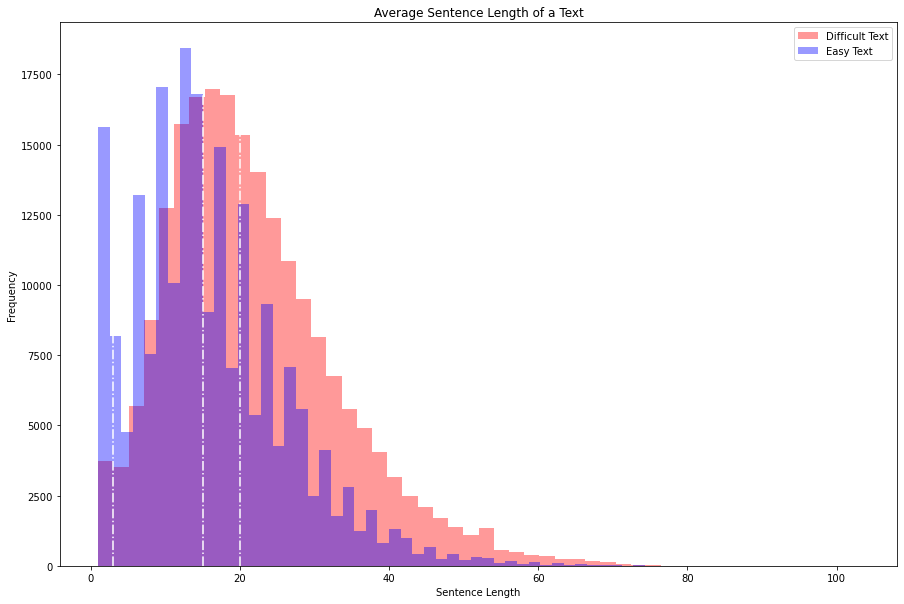

,original_text,norm_text,nlp_norm_text,lemma,pos,label,english,pca1,pca2,pca3,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,There is manuscript evidence that Austen conti...,there is manuscript evidence that austen conti...,there is manuscript evidence that austen conti...,"['there', 'be', 'manuscript', 'evidence', 'tha...","['PRON', 'AUX', 'NOUN', 'NOUN', 'SCONJ', 'PROP...",1,1,-1.241217,0.088320,-0.179642,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,in a remarkable comparative analysis mandaean ...,"['in', 'a', 'remarkable', 'comparative', 'anal...","['ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'PROPN', ...",1,1,-0.709833,0.029789,-0.094246,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182
2,"Before Persephone was released to Hermes , who...",before persephone was released to hermes who h...,before persephone was released to hermes who h...,"['before', 'persephone', 'be', 'release', 'to'...","['ADP', 'PROPN', 'AUX', 'VERB', 'ADP', 'PROPN'...",1,1,-1.476741,0.121393,-0.185596,...,1.0,0.0,2.0,0.0,0.0,0.0,66,42,6,4.642857


In [2]:
df_base = pd.read_csv('extracted_train_features_with_stopwords_pca.csv')
# Hist plot:
_ = plt.figure(figsize = (15,10))
_ = plt.hist(x ='sent_length',
             data = df_base[df_base['label']==1],
             color = 'red',
             alpha = 0.4,
             label = 'Difficult Text',
             bins = 50)

_ = plt.hist(x ='sent_length',
             data = df_base[df_base['label']==0],
             color = 'blue', 
             alpha = 0.4,
             label = 'Easy Text',
             bins = 50)

_ = plt.axvline(x = 3, ls ='-.', color = 'white')
_ = plt.axvline(x = 15, ls ='-.', color = 'white')
_ = plt.axvline(x = 20, ls ='-.', color = 'white')
_ = plt.xlabel('Sentence Length')
_ = plt.ylabel('Frequency')

_ =plt.legend()
_ =plt.title('Average Sentence Length of a Text')
_ = plt.show()

df_base.head(3)

In [3]:
# Threshold model: 
# Calculate recall, precision, f1-score and accuracy: 
# For different values of sentence length: Say 5,10,15

@lru_cache(16)
def threshold_model(col):
    
    di = {}
    for i in [5, 15, 20]:
        df_base['th_label'] = np.where(df_base[col]>=i,1,0)

        # Recall = TruePositives / (TruePositives + FalseNegatives)
        tp = df_base['th_label'][(df_base['label']==1) & (df_base['th_label']==1)].count()

        fn = df_base['th_label'][(df_base['label']==0) & (df_base['th_label']==1)].count()

        r = tp/(tp+fn)

        # Precision = TruePositives / (TruePositives + FalsePositives)

        fp = df_base['th_label'][(df_base['label']==1) & (df_base['th_label']==0)].count()

        p = tp/(tp+fp)


        # F-Measure = (2 * Precision * Recall) / (Precision + Recall)

        f_score = (2* p * r) / (p +r)

        # Accurcay: (TP+TN)/(TP+TN+FP+FN): 

        tn = df_base['th_label'][(df_base['label']==0) & (df_base['th_label']==0)].count()

        a = (tp+tn)/(tp+tn+fp+fn)

        di[i] = [r, p, f_score, a]
        
    df_threshold =  pd.DataFrame(di, index= ['Recall', 'Precision', 'F_score', 'Accuracy']) 
    df_threshold.index.name= col
    df_plot = df_threshold.plot(figsize = (15,5), style = 'o-')
    _ = plt.title('Threshold Score:' + " " +str.upper(col))
    _ = plt.ylabel('Threshold Score')
    _ = plt.show()
        
        
    return df_plot, display(df_threshold)
    


In [4]:
def plot():
    return [threshold_model(col = i) for i in ['sent_length', 'avg_wrd_len', 'NOUN', 'ADJ']]

# Varying sentence length between various iterations from 1 to 20, shows variation in Threshold scores
# in predicting text difficulty
# Example: At threshold 10, precision, recall
#          while at threshold 25 recall was higher at 64%
# Score shown below is at threshold 20. 

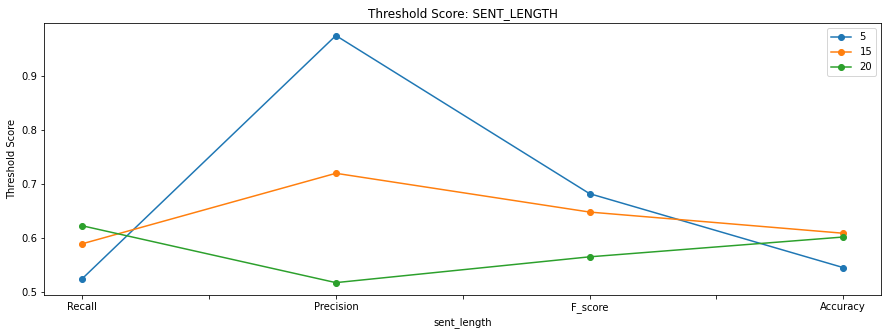

,5,15,20
sent_length,,,
Recall,0.524131,0.588769,0.622119
Precision,0.974587,0.719354,0.516772
F_score,0.681664,0.647544,0.564573
Accuracy,0.544689,0.608302,0.601282


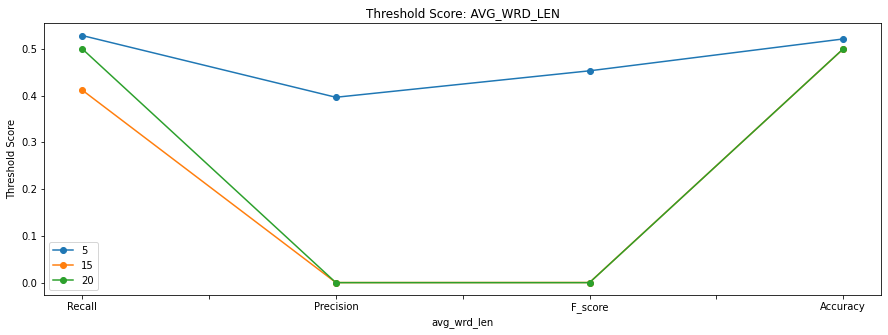

,5,15,20
avg_wrd_len,,,
Recall,0.528495,0.411765,0.500000
Precision,0.396456,0.000134,0.000005
F_score,0.453051,0.000269,0.000010
Accuracy,0.521186,0.499773,0.499802


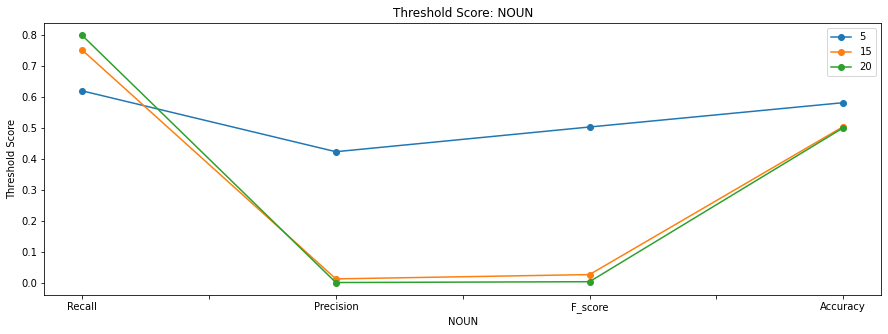

,5,15,20
NOUN,,,
Recall,0.619843,0.751188,0.798295
Precision,0.423939,0.014428,0.002699
F_score,0.503507,0.028313,0.005380
Accuracy,0.581800,0.504628,0.500811


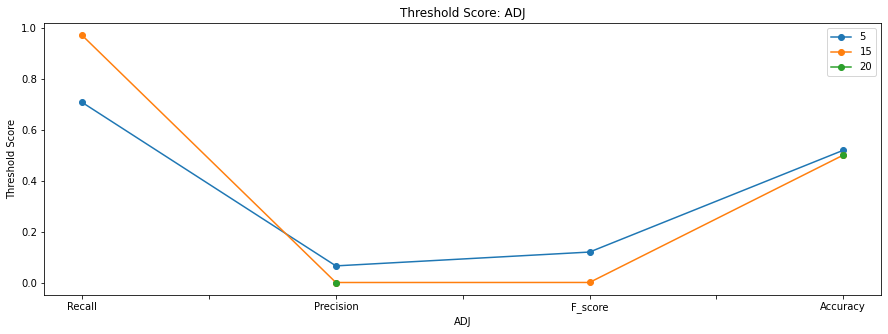

,5,15,20
ADJ,,,
Recall,0.706680,0.969697,NaN
Precision,0.065345,0.000154,0.000000
F_score,0.119629,0.000307,NaN
Accuracy,0.518921,0.499876,0.499802


[(<matplotlib.axes._subplots.AxesSubplot at 0x7fe956ff54e0>, None),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fe943c9a198>, None),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fe933ae38d0>, None),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fe954ef3710>, None)]

In [5]:
plot()



#### 2. Logistics Regression: 

In [6]:

@lru_cache(16)
def lr_svm_model(file,estimator):
    
    # Read feature set:
    df = pd.read_csv(file)
    
    
    # K-fold: 
    kfold = KFold(n_splits=5, shuffle=True, random_state = 0)

    # Train and label  Data : 
    X = df.iloc[:,6:]
    y = df['label']

    X.shape, y.shape

    # Make pipeline: 

    pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', estimator)])
    accuracy = np.mean(cross_val_score(pipeline, X, y, cv = kfold))
    #recall = np.mean(cross_val_score(pipeline, X, y, cv = kfold, scoring='recall'))
    #precision = np.mean(cross_val_score(pipeline, X, y, cv = kfold, scoring='precision'))
    #f_score = np.mean(cross_val_score(pipeline, X, y, cv = kfold, scoring='f1'))
    

    return accuracy#, recall, precision, f_score)

In [7]:
%%time

file = 'extracted_train_features_with_stopwords_pca.csv'
score_base = pd.DataFrame({'Logistics Regression': lr_svm_model(file, LogisticRegression(random_state=0)), 
                          'Support Vector Machine': lr_svm_model(file, SGDClassifier(random_state=0))},
                          index = ['Mean Accuracy'])



CPU times: user 29.1 s, sys: 1.35 s, total: 30.4 s
Wall time: 21 s


In [8]:
score_base

,Logistics Regression,Support Vector Machine
Mean Accuracy,0.63582,0.629842


#### 3. Trees/Ensemble Models: 

In [9]:
@lru_cache(16)
def tree_models(file, estimator):
        # Read feature set:
    df = pd.read_csv(file)
    
    # Train and label  Data : 
    X = df.iloc[:,6:]
    y = df['label']
        
    # K-fold: 
    kfold = KFold(n_splits=5, shuffle=True, random_state = 0)
    accuracy = np.mean(cross_val_score(estimator, X, y, cv = kfold))

    
    return accuracy

In [10]:
%%time
file = 'extracted_train_features_with_stopwords_pca.csv'
score_trees = pd.DataFrame({'Random Forest': tree_models(file, RandomForestClassifier(n_estimators=100, random_state= 0, n_jobs= -1, verbose = 0)), 
                      'XGBRFC': tree_models(file, XGBRFClassifier(n_estimators= 100, random_state=0, n_jobs = -1, verbose = 0)),
                      'XGBC': tree_models(file, XGBClassifier(n_estimators = 100, random_state=0, n_jobs = -1, verbose = 0))},
                     index = ['Mean Accuracy'])


CPU times: user 12min, sys: 7.99 s, total: 12min 8s
Wall time: 15min 12s


In [11]:
score_trees

,Random Forest,XGBRFC,XGBC
Mean Accuracy,0.703435,0.649978,0.671083


In [12]:
# While running multiple feature iterations, it was observed that Randomforest w/o stopwords resulted in 70%, 69% model accuracy. 
# This was nominal difference but stopwords did contribute in classifying text difficulty. 

#### 4. Selected Model for GridSerachCV: 
1. We will use <b>Random forest</b> as our selected model due to high model accuracy

In [13]:
# Apply Grid Search CV on Random Forest:
from sklearn.model_selection import train_test_split
@lru_cache(16)
def randomforest_gridsearchCV(file):
        # Read feature set:
    df = pd.read_csv(file)
    
    # Train and label  Data: 
    X = df.iloc[:,6:]#.sample(frac= 0.1)
    y = df['label']#.sample(frac= 0.1)
    
    # Train test split: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True)
        
    # K-fold: 
    kfold = KFold(n_splits=3, shuffle=True, random_state = 0)
    
    # build pipeline: 
    rf_pipeline = Pipeline([('rf', RandomForestClassifier(random_state= 0,
                                                          verbose=0))])
    # define grid parameters: 
    parameters = {'rf__criterion': ['gini', 'entropy'], 
              'rf__max_features': ['auto', 'sqrt'],
             #'rf__max_depth': [5, 8, 10],                  #Removed 
              'rf__n_estimators': [100, 200]}
    # initiate grid
    grid_rf = GridSearchCV(estimator= rf_pipeline , 
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold,
                           return_train_score = False,
                           verbose=1,
                           n_jobs=-1)
    
    # fit grid
    grid_rf_result = grid_rf.fit(X_train, y_train)

    # get best parameters and score
    return grid_rf_result.best_params_, grid_rf_result.best_score_

In [14]:
%%time
file = 'extracted_train_features_with_stopwords_pca.csv'
rf_grid_result = randomforest_gridsearchCV(file)

print(rf_grid_result)
# By restricting max_depth to 10, model accuracy reduced to 66%.
# This feature seems to influence the model quite a bit. 
# Also, I prefer to use 'gini' as a criterion because it's requires lesser computational resources than entropy index.    

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 13.2min finished


({'rf__criterion': 'entropy', 'rf__max_features': 'auto', 'rf__n_estimators': 200}, 0.6946854419488814)
CPU times: user 3min 45s, sys: 1.99 s, total: 3min 47s
Wall time: 16min 56s


#### RF Grid SearchCV Parameters: (23 mins) 
{'n_estimators': 200, 'max_features': 'auto, 'max_depth': 10, 'criterion': 'gini'}  #criterion changed to gini


In [15]:
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
@lru_cache(16)
def randomforest_tuned_model(file):
    
    # Read feature set:
    df = pd.read_csv(file)
    
    # Train and label  Data : 
    X = df.iloc[:,6:]
    y = df['label']
    
    # Train test split: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True)
    
    # pipeline: 
    model_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=200,
                                                                   #max_depth= 10,
                                                                   max_features= 'auto',
                                                                   criterion = 'gini',
                                                                   random_state= 0,
                                                                   n_jobs= -1,
                                                                   verbose = 1))])
    # fit model:
    model_rf.fit(X_train, y_train)
    
    # predict:
    y_pred_rf = model_rf.predict(X_test)
    
    # predict proba:
    y_predproba_rf = model_rf.predict_proba(X_test)[:,1]

    
    return model_rf, y_test, y_pred_rf, y_predproba_rf

In [16]:
%%time
file = 'extracted_train_features_with_stopwords_pca.csv'
model_rf, y_test, y_pred_rf, y_predproba_rf = randomforest_tuned_model(file)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   56.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


CPU times: user 3min 48s, sys: 1.87 s, total: 3min 50s
Wall time: 1min 4s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


In [17]:
### feature Importance:

In [18]:

# Random Forest Evaluation on Extracted Features
rf_extracted_summary = round(pd.DataFrame({'Random_Forest_Extracted': [accuracy_score(y_test, y_pred_rf),
                                               precision_score(y_test, y_pred_rf),
                                               recall_score(y_test, y_pred_rf),
                                               f1_score(y_test, y_pred_rf),
                                               roc_auc_score(y_test, y_pred_rf)]}, index = ['Accuracy','Precision','Recall','F1_score','ROC_AUC']),2) 
           
      
# Feature Importance:
rf_extracted_fi = (pd.DataFrame(list(zip(df_base.iloc[:, 6:].columns, (model_rf.named_steps['rf'].feature_importances_)*100)),
                              columns = ['Features_Extracted', '%Importance_Extracted'])
                 .sort_values(by ='%Importance_Extracted', ascending = False))


In [19]:
display(rf_extracted_summary, rf_extracted_fi.head(10))

,Random_Forest_Extracted
Accuracy,0.71
Precision,0.70
Recall,0.72
F1_score,0.71
ROC_AUC,0.71


,Features_Extracted,%Importance_Extracted
29,avg_wrd_len,7.814871
1,pca1,7.511609
5,pca5,7.440699
26,nsyll,7.417475
6,pca6,7.218217
2,pca2,7.188187
4,pca4,7.136168
3,pca3,7.013215
27,sent_length,5.416655
7,count_lemma_85_above,4.649767


## 2. Build Random Forest with text Tokenizers:
1. Compare difference between extracted and tokenized model

In [20]:
# Also try fitting RF with count vectorizer and TFIDF: 
@lru_cache(16)
def model_with_ngram(file, estimator):
    
    # Read feature set:
    df = pd.read_csv(file)
    
    # Train and label  Data converted to numpy array: 
    X = df['norm_text'].values
    y = df['label'].values
    
    # Train test split: 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle= True)
    
    # Tokenize Text using Count vectorizer
    # initiate Count vectorizer: 
    countvect = CountVectorizer(ngram_range=(1,2), max_features=2000) #same as unsupervised model 
    
    # get count train:
    count_train = countvect.fit_transform(X_train)
    # get count test: 
    count_test = countvect.transform(X_test)
    
    # Tokenize countvect text using TFIDF transformer:
    # initiate tfidf
    tfidf = TfidfTransformer(use_idf = True)
    
    # get tfidf train: 
    tfidf_train = tfidf.fit_transform(count_train)
    # get tfidf test: 
    tfidf_test = tfidf.transform(count_test)
    
    # pipeline: 
    model = Pipeline([('estimator', estimator)])
    
    # fit model:
    model.fit(tfidf_train, y_train)
    
    # predict:
    y_pred = model.predict(tfidf_test)
    
    # predict proba:
    y_pred_proba = model.predict_proba(tfidf_test)

    
    return model, y_test, y_pred, y_pred_proba, countvect

In [21]:
%%time
# Random forest using Tokenizer: 
file = 'extracted_train_features_with_stopwords_pca.csv'
model_rf_ngram, y_test, y_pred_rf_ngram, y_predproba_rf_ngram, countvect = model_with_ngram(file, RandomForestClassifier(n_estimators=200, 
                                                                                                             max_features= 'auto',                                                                 
                                                                                                             criterion = 'gini',
                                                                                                             random_state= 0,
                                                                                                             n_jobs= -1,
                                                                                                             verbose = 1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 32.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.6s finished


CPU times: user 1h 59min 45s, sys: 46.2 s, total: 2h 31s
Wall time: 32min 31s


In [22]:
# Random Forest Evaluation on Extracted Features
rf_tokenized_summary = pd.DataFrame({'Random_Forest_Tokenized': [accuracy_score(y_test, y_pred_rf_ngram),
                                               precision_score(y_test, y_pred_rf_ngram),
                                               recall_score(y_test, y_pred_rf_ngram),
                                               f1_score(y_test, y_pred_rf_ngram),
                                               roc_auc_score(y_test, y_pred_rf_ngram)]}, index = ['Accuracy','Precision','Recall','F1_score','ROC_AUC']) 

print("Accuracy_score at max_features 2000 was: 0.6863828560445897. Run time 36min 42s")
print("Accuracy_score at max_features 1000 was: 0.6824428214491639. Run time 27min 55s")
print("Accuracy_score at max_features 32 was: 0.6386219488756487. Run time 9 min 5s")


# Feature Importance with Stopwords:
rf_tokenized_fi = (pd.DataFrame(list(zip(countvect.get_feature_names(), (model_rf_ngram.named_steps['estimator'].feature_importances_)*100)),
                              columns = ['Features_Tokenized', '%Importance_Tokenized'])
                 .sort_values(by ='%Importance_Tokenized', ascending = False))


# Feature Importance without Stopwords: 
stopword = list(stopwords.words('english'))

rf_tokenized_nonstopwords_fi = rf_tokenized_fi[~rf_tokenized_fi['Features_Tokenized'].isin(stopword)]


display(rf_tokenized_fi, rf_tokenized_summary, rf_tokenized_nonstopwords_fi)   



Accuracy_score at max_features 2000 was: 0.6863828560445897. Run time 36min 42s
Accuracy_score at max_features 1000 was: 0.6824428214491639. Run time 27min 55s
Accuracy_score at max_features 32 was: 0.6386219488756487. Run time 9 min 5s


,Features_Tokenized,%Importance_Tokenized
1621,the,2.432119
70,and,2.100280
1130,of,1.805067
743,in,1.590116
810,is,1.290981
...,...,...
1519,south western,0.005649
1251,picardy in,0.005581
1358,region basse,0.005532
1433,sarthe department,0.003273


,Random_Forest_Tokenized
Accuracy,0.686383
Precision,0.683174
Recall,0.696713
F1_score,0.689877
ROC_AUC,0.686369


,Features_Tokenized,%Importance_Tokenized
1404,rrb,0.851787
961,lrb,0.825859
1080,ndash,0.725014
1143,of the,0.632228
775,in the,0.588742
...,...,...
1519,south western,0.005649
1251,picardy in,0.005581
1358,region basse,0.005532
1433,sarthe department,0.003273


### Observations:
1. Model accuracy w.r.t change in max_features parameter in count_vectorizer.  
2. Stopwords combined with other text can cause text difficulty. 
    1.Example:  stopword 'the' contributes upto 2.43% in text difficulty, which can add up if combined with other words.
    
The model we used here, was a unigram-to-bigram. Use of stopwords in higher order n-grams could be more sensitive. 



## Model Evaluation Summary Results: 
1. Base Models
2. Random forest with extracted features
3. Random Forest with n_gram Tokenizer

,Logistics Regression,Support Vector Machine,Random Forest,XGBRFC,XGBC
Base Models,,,,,
Mean Accuracy,0.63582,0.629842,0.703435,0.649978,0.671083


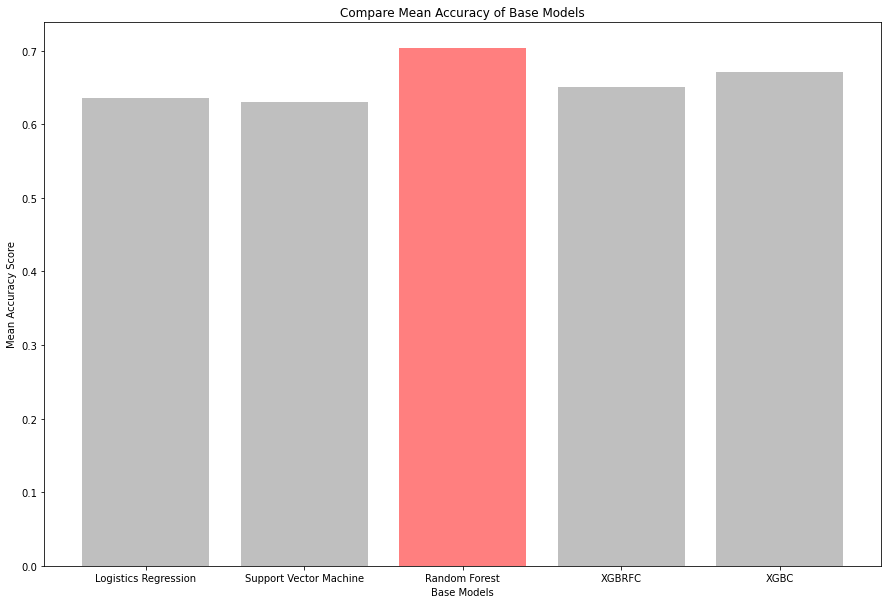

In [23]:
# Plot Base Models: 
cross_val_base_models = pd.concat([score_base, score_trees], axis = 1)
cross_val_base_models.index.name = 'Base Models'

display(cross_val_base_models)

_ = plt.figure(figsize= (15,10))
clrs = ['grey' if (x < max(cross_val_base_models.loc['Mean Accuracy'])) else 'red' for x in cross_val_base_models.loc['Mean Accuracy']]
_ = plt.bar(x = cross_val_base_models.columns, height = cross_val_base_models.loc['Mean Accuracy'], color = clrs, alpha = 0.5)
_ = plt.xlabel('Base Models')
_ = plt.ylabel('Mean Accuracy Score')
_ = plt.title('Compare Mean Accuracy of Base Models')


,Random_Forest_Extracted,Random_Forest_Tokenized
Random Forest Models,,
Accuracy,0.71,0.686383
Precision,0.70,0.683174
Recall,0.72,0.696713
F1_score,0.71,0.689877
ROC_AUC,0.71,0.686369


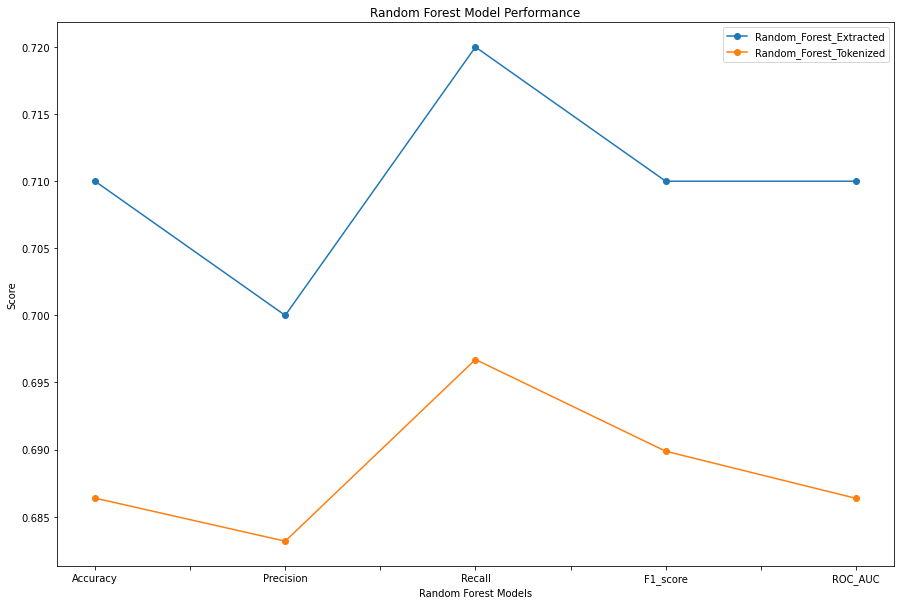

In [24]:
# Plot RF Model Score: 
rf_model_scores = pd.concat([rf_extracted_summary, rf_tokenized_summary], axis = 1)
rf_model_scores.index.name = 'Random Forest Models'

display(rf_model_scores)
rf_model_scores = pd.concat([rf_extracted_summary, rf_tokenized_summary], axis = 1)
rf_model_scores.index.name = 'Random Forest Models'
rf_model_scores.plot(figsize= (15, 10), style = 'o-')
_ = plt.title('Random Forest Model Performance')
_ =plt.ylabel('Score')
_ = plt.show()


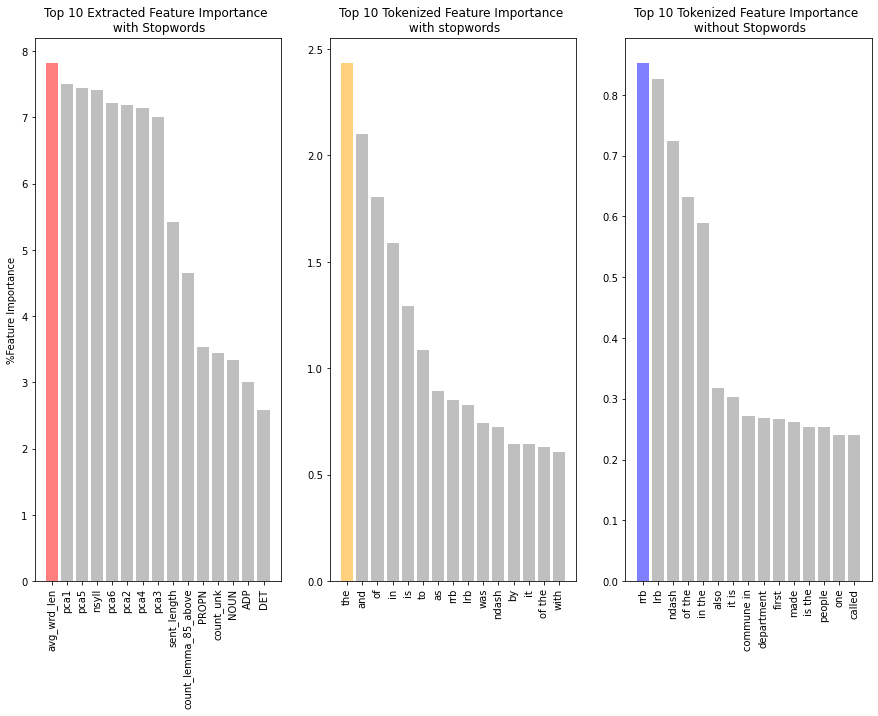

In [25]:
# PLot Feature Importance:
_ = plt.figure(figsize= (15,10))

_ = plt.subplot(1,3,1)
clrs = ['grey' if (x < max(rf_extracted_fi['%Importance_Extracted'])) else 'red' for x in rf_extracted_fi['%Importance_Extracted']]
_ = plt.bar(x= 'Features_Extracted', height='%Importance_Extracted', data = rf_extracted_fi.head(15), color = clrs, alpha = 0.5)
_ = plt.xticks(rotation = 90)
_ = plt.ylabel("%Feature Importance")
_ = plt.title("Top 10 Extracted Feature Importance \n with Stopwords")

_ = plt.subplot(1,3,2)
clrs_2 = ['grey' if (x < max(rf_tokenized_fi['%Importance_Tokenized'])) else 'orange' for x in rf_tokenized_fi['%Importance_Tokenized']]
_ = plt.bar(x= 'Features_Tokenized', height='%Importance_Tokenized', data = rf_tokenized_fi.head(15), color = clrs_2, alpha = 0.5)
_ = plt.xticks(rotation = 90)
_ = plt.title("Top 10 Tokenized Feature Importance \n with stopwords")

_ = plt.subplot(1,3,3)
clrs_3 = ['grey' if (x < max(rf_tokenized_nonstopwords_fi['%Importance_Tokenized'])) else 'blue' for x in rf_tokenized_nonstopwords_fi['%Importance_Tokenized']]
_ = plt.bar(x= 'Features_Tokenized', height='%Importance_Tokenized', data = rf_tokenized_nonstopwords_fi.head(15), color = clrs_3, alpha = 0.5)
_ = plt.xticks(rotation = 90)
_ = plt.title("Top 10 Tokenized Feature Importance \n without Stopwords")


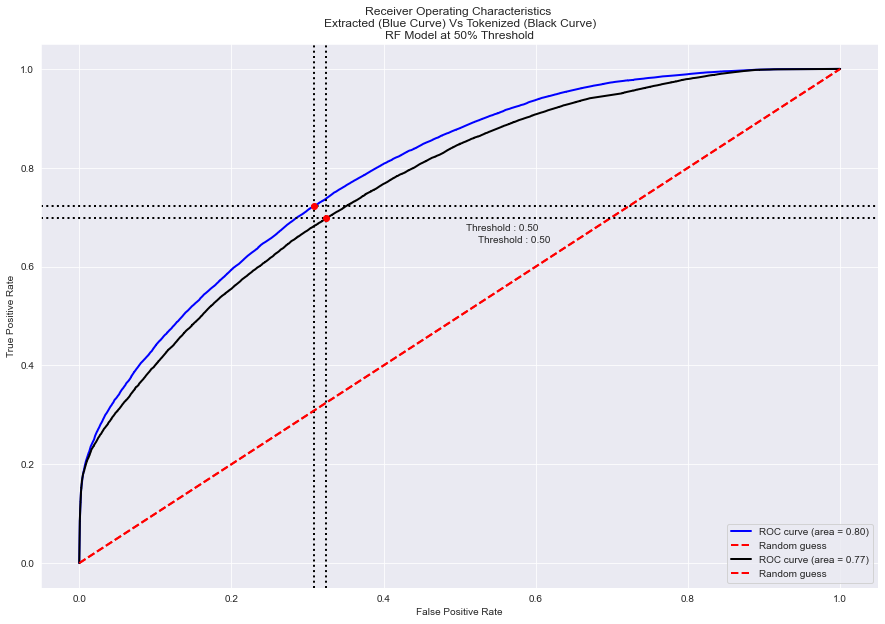

In [33]:
# Plot of ROC Curve:  
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
rf_extracted = BinaryClassification(y_test, y_predproba_rf, labels=["Class 1", "Class 2"])
rf_tokenized = BinaryClassification(y_test, y_predproba_rf_ngram[:,1], labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(15,10))
rf_extracted.plot_roc_curve(c_roc_curve='blue', threshold = 0.5)
rf_tokenized.plot_roc_curve()
_ = plt.title('Receiver Operating Characteristics \nExtracted (Blue Curve) Vs Tokenized (Black Curve)\nRF Model at 50% Threshold')
plt.show()


# AUC ROC score for Extracted Random forest model is 80% at 50% threshold as shown by the blue curve. 

### Observations: 
1. Random Forest using extracted features recorded >70% model accurcay, ROC curve area 0.80. 
2. Removing corrupted data (unknown & non-english words) might result in better model accuracy.  
3. Average Word length and PCA features contributed >7% in classifying text difficulty.
4. Feature importance of stopswords in Tokenized Rand Forest Model, shows that stopwords combined with other words can result in higher text difficulty. Because stopwords can increase average word length making a sentence longer and more difficult to understand for learners. 
5. Tokenized model was able to identify 'rrb' and 'lrb' in contributing to text difficulty. 